### Create Embedding for the visualizer

This notebook shows how to create embeddings for the PCA / tSNE visualizer in tensorboard. We use a trained VGG16 network and feed CIFAR images through it.

The final result looks like: 

![](embeddings.png)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import scipy
import cPickle
%matplotlib inline
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
tf.__version__

'1.0.1'

### Loading of the data

The 32x32 CIFAR images we use here can be obtained from: http://www.cs.toronto.edu/~kriz/cifar.html 

In [84]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    data = dict['data']
    imgs = np.transpose(np.reshape(data,(-1,32,32,3), order='F'),axes=(0,2,1,3)).astype(np.float) #order batch,x,y,color
    y = np.asarray(dict['fine_labels'], dtype='uint8')
    return y, imgs

In [167]:
y, imgs = unpickle('/usr/stud/plapp/data/cifar100/train')

y.shape, imgs.shape

((50000,), (50000, 32, 32, 3))

### Defining the models

We use a trained VGG16 network. As a first step we download the VGG16 weights (filename vgg_16.tar.gz) from [here](https://github.com/tensorflow/models/blob/master/slim/README.md#Pretrained) and extract it. After extraction you should get a file named vgg_16.ckpt.

For more details refere to http://randomthoughtsonr.blogspot.de/2016/11/image-classification-in-r-using-trained.html

In [4]:
import semisup

from tools.cifar100 import tree
from tools.tree import findLabelsFromTree, getWalkerLabel
from tools import cifar100 as cifar_tools, dataset_factory, preprocessing_factory, cifar100, data_dirs


tf.reset_default_graph()


preprocessing_name = "cifarnet"#FLAGS.preprocessing_name or FLAGS.model_name
image_preprocessing_fn = preprocessing_factory.get_preprocessing(
  preprocessing_name,
  is_training=False)


image = tf.placeholder(tf.float32, [32,32,3])


test_images = image_preprocessing_fn(image, 32, 32)


model = semisup.SemisupModel(semisup.architectures.cifar_model, tree.num_labels,
                             [32,32,3], treeStructure=tree)

variables_to_restore = slim.get_variables_to_restore()
print('Number of variables to restore {}'.format(len(variables_to_restore)))

init_assign_op, init_feed_dict = slim.assign_from_checkpoint('/usr/stud/plapp/model.ckpt-60000', variables_to_restore)
sess = tf.Session()
sess.run(init_assign_op, init_feed_dict)  


shape (?, 32, 32, 3)
Number of variables to restore 11


In [168]:
# preprocess images
for i in range(1000):
    imgs[i] = test_images.eval(feed_dict={image: imgs[i]}, session=sess)
    #imgs[i] = imgs[i]/128-1

In [169]:
g = tf.get_default_graph()
#print g.get_operations()
feed = g.get_tensor_by_name('test_in:0')
fetch = g.get_tensor_by_name('net/fc4/Relu:0')
label = g.get_tensor_by_name('net_1/fully_connected/BiasAdd:0')

# Feeding 3 images through the net just for testing
feed_vals = imgs[0:1000]

res = sess.run([fetch, label], feed_dict={feed:feed_vals})
np.shape(feed_vals), res[1].shape

((1000, 32, 32, 3), (1000, 120))

ground truth: 42
most likely coarse classes: [12  8  7 15  6 10 17  0 19 13]
related logits: [ 1.01942956  0.86832899  0.70651525  0.62451327  0.17117521]
prediction: (possibly need to add 1) ([12, 62], 62)
fine class logits for pred 0: [-8.49073601 -7.36486721  0.53795868 -1.03592944  0.31727153]
fine class logits for pred 1: [-4.96882248  1.91470695 -1.05156434 -3.51446295 -4.04340219]
fine class logits for pred 2: [-0.98038787 -2.81841326  3.4541347  -7.75325727 -7.52504301]
fine class logits for ground truth coarse: [-4.96882248  1.91470695 -1.05156434 -3.51446295 -4.04340219]
accuracy: 0.429


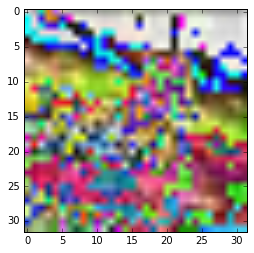

In [204]:
i=85
#print(imgs[i])
plt.imshow(imgs[i])

print "ground truth:", y[i]
s = res[1][i][0:20].argsort()[-10:][::-1]
print "most likely coarse classes:", s
print "related logits:", np.sort(res[1][i][0:20])[-5:][::-1]

print "prediction: (possibly need to add 1)", findLabelsFromTree(tree, res[1][i])  
print "fine class logits for pred 0:", res[1][i][s[0]*5+20:s[0]*5+25]
print "fine class logits for pred 1:", res[1][i][s[1]*5+20:s[1]*5+25]
print "fine class logits for pred 2:", res[1][i][s[2]*5+20:s[2]*5+25]

print "fine class logits for ground truth coarse:", res[1][i][int(np.floor((y[i]-1)/5)*5+20):int(np.floor((y[i]-1)/5)*5+25)]

correct=[]
for j in range(1000):
    label = findLabelsFromTree(tree, res[1][j])
    
    if label[1]+1 == y[j]:
        correct = correct + [j]
        
print "accuracy:", float(len(correct))/1000


### Getting the embedding

We now create a $N \times p$ matrix holding the embeddings, for the N images. For simplycify, we do this by feeding the images one after another through the network (of course we could have also used minibatches). We store this matrix in `EMB` to use it later.

In [174]:
N = imgs.shape[0]
N = 1000 #For testing 
p = res[0].shape[1]

EMB = np.zeros((N, p), dtype='float32')
for i in range(N): #Of course you could do mini-batches
    EMB[i] = sess.run(fetch, feed_dict={feed: imgs[i:i+1,:]})
    if (i % 50 == 0 or i < 5):
        print(i)

0
1
2
3
4
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


### Writing out the embedding matrix
We now write out the embedding matrix in the proper format needed for the visualizer. If you don't want images or meta data, just comment out the respective parts.

In [188]:
LOG_DIR = '/usr/stud/plapp/cifarVisualization'

# The embedding variable, which needs to be stored
# Note this must a Variable not a Tensor!
embedding_var = tf.Variable(EMB,  name='Embedding_of_fc4')
sess.run(embedding_var.initializer)
summary_writer = tf.summary.FileWriter(LOG_DIR)
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Comment out if you don't have metadata
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Comment out if you don't want sprites
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite.png')
#embedding.sprite.single_image_dim.extend([imgs.shape[1], imgs.shape[1]])

projector.visualize_embeddings(summary_writer, config)
saver = tf.train.Saver([embedding_var])
saver.save(sess, os.path.join(LOG_DIR, 'model4.ckpt'), 1)

'/usr/stud/plapp/cifarVisualization/model4.ckpt-1'

### Creation of the meta data (labels)

In [13]:
names = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']
metadata_file = open(os.path.join(LOG_DIR, 'metadata.tsv'), 'w')
metadata_file.write('Name\tClass\n')
for i in range(N):
    metadata_file.write('%06d\t%s\n' % (i, 'class'+str(y[i])))
metadata_file.close()

### Creation of the images

In [29]:
# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding

    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [30]:
sprite = images_to_sprite(imgs)
scipy.misc.imsave(os.path.join(LOG_DIR, 'sprite.png'), sprite)

In [19]:
%ls -lhl /tmp/dumm/ 

total 139768
-rw-r--r--  1 oli  wheel   103B Dec 16 18:36 checkpoint
-rw-r--r--  1 oli  wheel    12K Dec 16 18:36 metadata.tsv
-rw-r--r--  1 oli  wheel    16M Dec 16 18:36 model2.ckpt-1.data-00000-of-00001
-rw-r--r--  1 oli  wheel   147B Dec 16 18:36 model2.ckpt-1.index
-rw-r--r--  1 oli  wheel    31M Dec 16 18:36 model2.ckpt-1.meta
-rw-r--r--  1 oli  wheel   199B Dec 16 18:36 projector_config.pbtxt
-rw-r--r--  1 oli  wheel    21M Dec 16 18:36 sprite.png
